In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from tqdm import tqdm, tqdm_notebook
sys.path.append('../../reproducible_figures/scripts/')
import rep_fig_vis as rfv
sys.path.append('../scripts/')
from loadpaths_glc import loadpaths
import data_loading_utils as dlu
import glc_prediction_utils as gpu
path_dict = loadpaths()

In [36]:
dict_dfs, dict_dfs_species, dict_val_species = dlu.load_metadata(create_geo=True, add_h3=False,
                                               create_validation_set=True)
# type(dict_dfs['df_test_pa'])

Dropped PO data because takes ages with geometry
Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']
Dropped 49637/1483637 duplicates in df_train_pa_species
Created validation set with 8898 entries


## Average within buffer with threshold

In [39]:
val_or_test = 'test'

dict_dfs, dict_dfs_species, dict_val_species = dlu.load_metadata(create_geo=True, add_h3=False,
                                create_validation_set=True if val_or_test == 'val' else False)
tmp = gpu.predict_using_buffer(dict_dfs=dict_dfs, dict_dfs_species=dict_dfs_species,
                            save_pred=True, method=f'lc-specific', buffer_deg=0.3,
                            eval_mode=val_or_test)
if val_or_test == 'val':
    f1_score = gpu.compute_f1_score_dicts(dict_val_species, tmp)
    print(f'F1 score: {f1_score}')

Dropped PO data because takes ages with geometry
Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']
Dropped 49637/1483637 duplicates in df_train_pa_species
    LandCover  count
0         0.0     25
1         1.0     15
2         2.0     18
3         4.0     22
4         5.0     16
5         8.0     20
6         9.0     16
7        10.0     19
8        11.0     14
9        12.0     17
10       13.0     16
11       14.0     17
12       15.0     11
13       16.0     12
14       17.0     13


 43%|████▎     | 2049/4716 [00:13<00:17, 149.13it/s]

No nearby points for surveyId: 1695841 (LC: 13.0)


100%|██████████| 4716/4716 [00:31<00:00, 151.01it/s]

Predictions done (4715 total). No nearby points: 1.
Saved predictions to: /Users/t.vanderplas/data_offline/data_geolifeclef2024/predictions_glc2024/GLC24_vdplasthijs_predictions-buffer-lc-0.3-lc-specific_2024-04-18_22-53.csv


## Label propagation

In [3]:
(df_train, df_test), (df_train_species, df_val_species) = dlu.create_full_pa_ds(val_or_test='test')

Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']
Dropped 49637/1483637 duplicates in df_train_pa_species
Dropped 135101/5079797 duplicates in df_train_po_species


In [7]:
df_tmp = df_train[[f'Bio{x}' for x in range(1, 20)]]

def gauss_dist_two_samples(df, i1=0, i2=1):
    vals1 = df.iloc[:, i1].values
    vals2 = df.iloc[:, i2].values

    mu = df.mean(0)
    cov = df.cov()

    dist = (vals1 - vals2)

gauss_dist_two_samples(df_tmp)

In [8]:
df_tmp.cov()

,Bio1,Bio2,Bio3,Bio4,Bio5,Bio6,Bio7,Bio8,Bio9,Bio10,Bio11,Bio12,Bio13,Bio14,Bio15,Bio16,Bio17,Bio18,Bio19
Bio1,469.185305,53.104204,2.935005,-1657.638815,472.528477,443.668066,28.860411,15.441916,1034.332376,452.843470,485.817020,-6.641072e+02,802.049618,-913.001705,813.129203,2.282272e+03,-2625.590683,-7815.570296,3.673081e+03
Bio2,53.104204,331.979271,10.119051,5432.156486,296.165786,-179.438637,475.604424,-162.201805,233.551456,120.493571,-42.141660,1.616764e+04,1719.363591,878.720490,-80.856908,5.081097e+03,3113.620483,1489.014570,4.992752e+03
Bio3,2.935005,10.119051,0.439561,65.105580,9.068441,-2.485379,11.553820,-10.613806,8.846472,3.685711,1.213572,5.218271e+02,35.118204,38.303884,-13.830002,1.162495e+02,135.808545,47.443775,1.806833e+02
Bio4,-1657.638815,5432.156486,65.105580,300916.931846,4828.798646,-8962.095949,13790.894595,5084.125738,-5842.331558,2059.823752,-6006.045817,1.701452e+05,31577.209023,3873.267418,6895.464174,9.279199e+04,4191.505501,61697.909635,8.068577e+03
Bio5,472.528477,296.165786,9.068441,4828.798646,695.284922,246.722496,448.562425,10.153717,1076.273643,538.589925,389.313332,6.612487e+03,1609.455488,-523.461573,798.421189,4.758081e+03,-1343.938185,-7040.286533,5.650038e+03
Bio6,443.668066,-179.438637,-2.485379,-8962.095949,246.722496,656.924533,-410.202037,18.901125,945.773695,338.030687,575.153784,-1.442790e+04,-1183.096673,-1373.789215,546.661975,-3.445079e+03,-4151.261089,-9775.460693,3.703132e+02
Bio7,28.860411,475.604424,11.553820,13790.894595,448.562425,-410.202037,858.764462,-8.747408,130.499948,200.559238,-185.840453,2.104039e+04,2792.552161,850.327642,251.759213,8.203160e+03,2807.322904,2735.174160,5.279725e+03
Bio8,15.441916,-162.201805,-10.613806,5084.125738,10.153717,18.901125,-8.747408,1405.728947,-348.710948,79.012951,-34.401188,-3.644903e+04,-3249.379734,-2523.496324,808.986408,-9.406679e+03,-9087.287319,-3843.396326,-1.228758e+04
Bio9,1034.332376,233.551456,8.846472,-5842.331558,1076.273643,945.773695,130.499948,-348.710948,3421.106294,982.555450,1112.900286,3.153828e+04,7437.772129,-1207.332577,2601.176759,1.935881e+04,-2166.030287,-18247.801551,2.017907e+04
Bio10,452.843470,120.493571,3.685711,2059.823752,538.589925,338.030687,200.559238,79.012951,982.555450,483.596520,416.941144,1.277899e+03,1203.715672,-886.763880,916.359609,3.444692e+03,-2656.580304,-7305.636907,3.794150e+03


## Label propagation idea:

- For each sample, define neighbourhood based on geographic distance to other points (eg 0.2 deg). I think this beats KNN because of huge differences in sampling density. 
- For two samples, define their weight as 1) some distance function of features like LC / sat / bioclim / soil. Embed features with PCA etc. first to reduce cost and improve metric of computing distance? Possible scale feature similarity with distance decay function.
- Implement label propagation algorithm to label test samples, based on weighted voting/average (per species I think) within neighbourhood. 
- So formally, we would have a G = (V, E, W), where V are the samples, E are defined by geographic distance, W are defined by features. These are all pre-computed. Labels L(V) are then computed iteratively.
- Pretty big data set (with PO even more so): use efficient data structures etc. Sparse matrix? Maybe you can do efficient col multiple + sum? Sparse; Save weights as sparse matrix (0 if no edge). Species labels as sparse mat. Then label prop is a matmul between W and L_t.
- Defining the (feature) distance function: option 1) optimising this, only feasible for a handful of hyperparams. Option 2) something based on features themselves. PCA is pretty good, other ways of maximising info? LC will be v important but tricky because it is categorical. 

In [10]:
tmp = gpu.LabelPropagation(dist_neigh_meter=30000,
                           val_or_test='test', method_weights='feature_dist',
                           filter_lc_exact_match=False, zscore_features=True,
                           preload_weights=True, weights_preload_timestamp='20240421-2043',
                           preload_labels=True, labels_preload_timestamp='20240421-2043')

Dropped PO data because takes ages with geometry
Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']
Dropped 49637/1483637 duplicates in df_train_pa_species
Z-scored 19 columns
Preloading weights from timestamp: 20240421-2043
Loaded sparse matrices from file


In [42]:
# tmp.mat_labels[0] * tmp.mat_labels[1]
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(tmp.mat_labels[0], tmp.mat_labels[1])

array([[0.]], dtype=float32)

In [ ]:
%timeit

In [46]:
tmp_cos = cosine_similarity(tmp.mat_labels, dense_output=False) 
tmp_cos

<93668x93668 sparse matrix of type '<class 'numpy.float32'>'
	with 3153021326 stored elements in Compressed Sparse Row format>

In [130]:
new_cos = sp.csr_matrix((tmp_cos.shape[0], tmp_cos.shape[1]))
for i in tqdm(range(tmp_cos.shape[0])):
    nz_ind_edge = tmp.mat_edges[i].nonzero()[1]
    new_cos[i, nz_ind_edge] = tmp_cos[i, nz_ind_edge]    


  0%|          | 0/93668 [00:00<?, ?it/s]/Users/t.vanderplas/anaconda3/envs/geoclef/lib/python3.10/site-packages/scipy/sparse/_index.py:136: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|██████████| 93668/93668 [57:20<00:00, 27.22it/s]  


In [52]:
tmp_cos.setdiag(np.zeros(tmp_cos.shape[0]))

/Users/t.vanderplas/anaconda3/envs/geoclef/lib/python3.10/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [132]:
sp.save_npz('/Users/t.vanderplas/data_offline/data_geolifeclef2024/geolifeclef-2024/sparse_format/mat_cos_labels_30km_20240516-2138.npz', new_cos)

In [131]:
new_cos

<93668x93668 sparse matrix of type '<class 'numpy.float64'>'
	with 18180944 stored elements in Compressed Sparse Row format>

0.1700577452615281


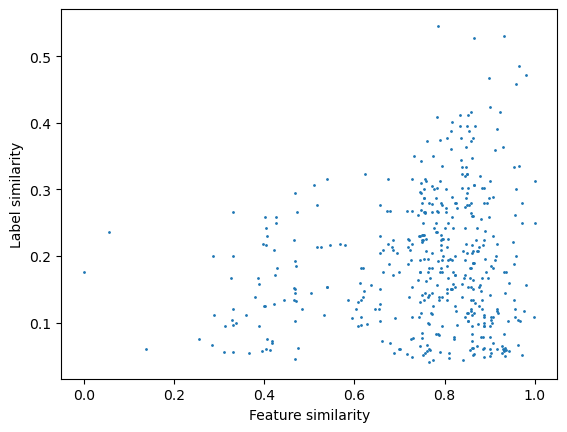

In [128]:
df_feat = tmp.df_train[['Elevation', 'Bio1', 'Bio2', 'Bio3', 'Bio4', 'Bio5', 'Bio6', 'Bio7', 'Bio8', 'Bio9', 'Bio10', 'Bio11', 'Bio12', 'Bio13', 'Bio14', 'Bio15', 'Bio16', 'Bio17', 'Bio18', 'Bio19']]
# df_feat = tmp.df_train[['LandCover']]
focal_ind = 120
# cos_use = tmp_cos
cos_use = new_cos
nz_inds = cos_use[focal_ind, :].nonzero()[1]
df_feat = df_feat.iloc[nz_inds, :] - df_feat.iloc[focal_ind, :]
dist_arr = df_feat.abs().sum(1).values
sim_arr_feat =  1 - dist_arr / dist_arr.max()
plt.scatter(sim_arr_feat, cos_use[focal_ind, nz_inds].toarray().flatten(), s=1)
plt.xlabel('Feature similarity')
plt.ylabel('Label similarity')
print(np.corrcoef(sim_arr_feat, cos_use[focal_ind, nz_inds].toarray().flatten())[0, 1])

In [109]:
3153026042 / 26643582

118.34092135209147

In [108]:
tmp.mat_edges

<93668x93668 sparse matrix of type '<class 'numpy.bool_'>'
	with 26643582 stored elements in Compressed Sparse Row format>

In [21]:
tmp.n_iter = 50
_ = tmp.fit()

  0%|          | 0/50 [00:00<?, ?it/s]/Users/t.vanderplas/anaconda3/envs/geoclef/lib/python3.10/site-packages/scipy/sparse/_base.py:713: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
/Users/t.vanderplas/anaconda3/envs/geoclef/lib/python3.10/site-packages/scipy/sparse/_index.py:136: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
Difference between epochs: 59.8: 100%|██████████| 50/50 [01:36<00:00,  1.92s/it]  

Converged after 50/50 iterations


- data points $i, j$: distance $d_{ij} = \sum_k | f_k(i) - f_k(j) | \cdot \nu_k$ such that $ 0 \leq d_{ij} < \inf$

- similarity then is: $s_{ij} = \frac{1}{\epsilon + d_{ij}}$, such that $ 0 < s_{ij} \leq \epsilon^{-1} $ (should therefore $\epsilon = 1$?)

- for satellite images; $f_k(i) = CNN(x_i | \theta)$ where $\theta$ is partly trained.
- for all others $f_k(i) = g(x_i)$ with no parameters to train. (either unity function, or PCA or something)

- For the species labels $y_i$, we define similarity as the cosine similarity: $s_{ij}^l = \frac{y_i \cdot y_j}{|| y_i || \cdot || y_j || }$ such that $0 \leq s_{ij}^l \leq 1$


Training: 
- Loss: $L(i, j) = MSE(s_{ij}, s_{ij}^l)$ if geographic distance $i, j < \tau$, else 0
- backprop $\{\nu_k, \theta\}$
- training: 1) take sample $i$, 2) find inds neighbours $< \tau$, 3) get matrix of $| f_k(i) - f_k(j) |$ (rows $j$, cols $k$), 4) multiply with $\nu_k$ and col-sum, 5) similarity and MSE loss, 6) backprop.
- CNN not sure ... ? 

Computed thresholds for test set


100%|██████████| 4716/4716 [04:34<00:00, 17.17it/s]


Predictions done. No species found: 11/4716.
Saved predictions to: /Users/t.vanderplas/data_offline/data_geolifeclef2024/predictions_glc2024/2024-05-15_14-34_GLC24_vdplasthijs_predictions-label-prop-lc-30000m-0.15.csv


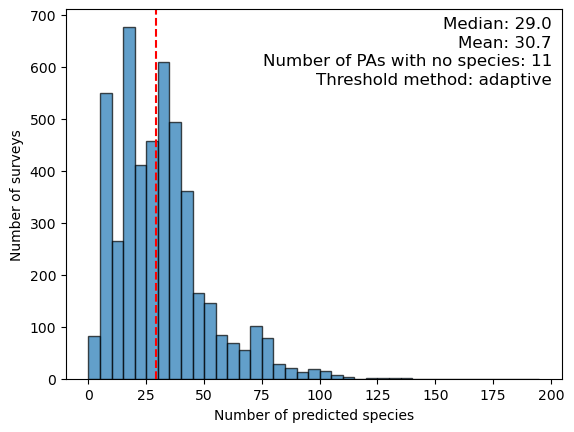

In [31]:
threshold_method = 'adaptive'
threshold_weighted_labels = 0.15
save_pred = True

dict_pred, count_no_species = tmp.create_predictions(threshold_method=threshold_method,
                                   threshold_weighted_labels=threshold_weighted_labels, 
                                   save_pred=save_pred)

ax = plt.subplot(111)
ax.hist([len(v) for k, v in dict_pred.items()], bins=np.arange(0, 200, 5),
         edgecolor='black', alpha=0.7);
ax.set_xlabel('Number of predicted species')
ax.set_ylabel('Number of surveys')
ax.axvline(np.median([len(v) for k, v in dict_pred.items()]), color='red', linestyle='dashed')

## print info in top righ tocrner
ax.text(0.98, 0.98, f'Median: {np.median([len(v) for k, v in dict_pred.items()])}',
        verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=12)

ax.text(0.98, 0.93, f'Mean: {np.round(np.mean([len(v) for k, v in dict_pred.items()]), 1)}',
        verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=12)

ax.text(0.98, 0.88, f'Number of PAs with no species: {count_no_species}',
        verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=12)

ax.text(0.98, 0.83, f'Threshold method: {threshold_method}',
        verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=12)

if threshold_method == 'fixed':
    ax.text(0.98, 0.78, f'Threshold: {threshold_weighted_labels}',
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=12)

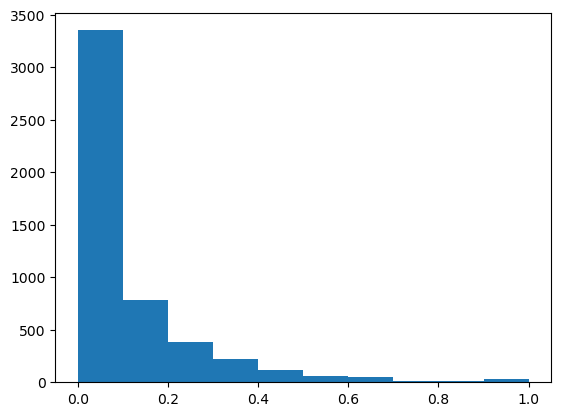

In [81]:
plt.hist(tmp.thresholds_test);

Text(0, 0.5, 'Val')

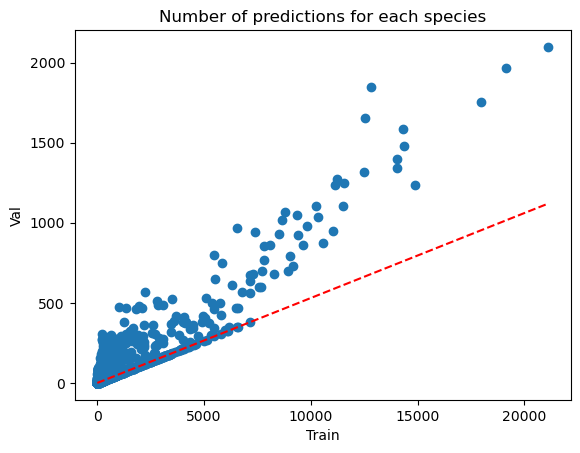

In [32]:
mat_train = sp.csc_matrix(tmp.mat_labels_thresholded[:tmp.n_train, :])
mat_val = sp.csc_matrix(tmp.mat_labels_thresholded[tmp.n_train:, :])

total_train = np.squeeze(np.array(mat_train.sum(axis=0)))
total_val = np.squeeze(np.array(mat_val.sum(axis=0)))
             
expected_slope = len(tmp.df_test) / tmp.n_train
x_exp = [0, np.max(total_train)]
y_exp = [0, expected_slope * np.max(total_train)]
plt.plot(x_exp, y_exp, color='red', linestyle='dashed')

plt.scatter(total_train, total_val)
plt.title('Number of predictions for each species')
plt.xlabel('Train')
plt.ylabel('Val')

# plt.xlim([0, 50])

In [ ]:
arr_th = [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3]
arr_f1 = []
for th in arr_th:
    dict_pred = tmp.create_predictions(threshold_weighted_labels=th)
    for k in dict_val_species.keys():
        if k not in dict_pred.keys():
            dict_pred[k] = []
    f1 = gpu.compute_f1_score_dicts(dict_val_species, dict_pred)
    arr_f1.append(f1)

In [55]:
print('F1 scores 20 km:')
for th, f1 in zip(arr_th, arr_f1):
    print(f'Th: {th}, F1: {f1}')

F1 scores 20 km:
Th: 0.01, F1: 0.17815909998542828
Th: 0.03, F1: 0.22171562850602888
Th: 0.05, F1: 0.2550898257417876
Th: 0.07, F1: 0.2813144225923728
Th: 0.1, F1: 0.31055241911795095
Th: 0.15, F1: 0.33787610690510994
Th: 0.2, F1: 0.34126959671664947
Th: 0.3, F1: 0.29877385480062507


In [51]:
for th, f1 in zip(arr_th, arr_f1):
    print(f'Th: {th}, F1: {f1}')

Th: 0.01, F1: 0.1993253455507175
Th: 0.03, F1: 0.2339567857022029
Th: 0.05, F1: 0.26306820509513906
Th: 0.07, F1: 0.2874202966047946
Th: 0.1, F1: 0.3149615778560888
Th: 0.15, F1: 0.34330129624560624
Th: 0.2, F1: 0.35171820741153903
Th: 0.3, F1: 0.32425812748704147


In [169]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
tmp_x = tmp.df_train.drop(columns=['surveyId', 'year', 'geometry'])
tmp_y = sp.csc_matrix(tmp.mat_labels[:tmp.n_train, :])
# tmp_y = tmp.mat_labels[:tmp.n_train, :][:, 0:10].toarray()

In [1]:
tmp_y

NameError: name 'tmp_y' is not defined

In [181]:

# for ii in tqdm(range(100)):
#     tmp_y_current = tmp_y[:, ii].toarray().flatten()
#     mi_scores = mutual_info_classif(tmp_x, tmp_y_current)
#     if ii == 0:
#         mi_scores_sum = mi_scores
#     else:
#         mi_scores_sum += mi_scores
# n_total = ii + 1
# mi_scores_sum /= n_total
inds_sorted = np.argsort(mi_scores_sum)[::-1]
for ind in inds_sorted:
    print(f'{tmp_x.columns[ind]},  {mi_scores_sum[ind]:.3f}')

# # Assuming X_train is your training data matrix and y_train are the corresponding labels
# # Select the top 50 features based on mutual information
# k_best = SelectKBest(score_func=mutual_info_classif, k=10)
# X_train_selected = k_best.fit_transform(tmp_x, tmp_y_current)

# # Get the indices of the selected features
# selected_feature_indices = k_best.get_support(indices=True)

# # Extract the names of the selected features
# selected_feature_names = [tmp_x.columns[i] for i in selected_feature_indices]


lat,  0.035
lng,  0.028
Bio12,  0.021
Bio9,  0.021
Bio10,  0.020
Bio4,  0.019
Bio14,  0.019
Bio1,  0.018
Bio17,  0.018
Bio18,  0.017
Bio5,  0.017
Bio2,  0.016
Bio19,  0.016
Bio8,  0.016
Bio11,  0.016
Bio15,  0.015
Bio7,  0.015
Elevation,  0.015
Bio16,  0.015
Bio3,  0.014
Bio6,  0.013
LandCover,  0.011
Bio13,  0.011
